In [1]:
#Luke Moore - PUBG Data Analysis and Cheat Detection

import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set_palette("viridis")

In [2]:
#Load the dataset - Downloaded from kaggle

PUBG_DF = pd.read_csv("pubg-finish-placement-prediction/train_V2.csv")

In [3]:
#Display information

PUBG_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

# Variable Information 

DBNOs - Number of enemy players knocked.

assists - Number of enemy players this player damaged that were killed by teammates.

boosts - Number of boost items used.

damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.

headshotKills - Number of enemy players killed with headshots.

heals - Number of healing items used.

Id - Player’s Id

killPlace - Ranking in match of number of enemy players killed.

killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.

killStreaks - Max number of enemy players killed in a short amount of time.

kills - Number of enemy players killed.

longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.

matchDuration - Duration of match in seconds.

matchId - ID to identify match. There are no matches that are in both the training and testing set.

matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.

rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.

revives - Number of times this player revived teammates.

rideDistance - Total distance traveled in vehicles measured in meters.

roadKills - Number of kills while in a vehicle.

swimDistance - Total distance traveled by swimming measured in meters.

teamKills - Number of times this player killed a teammate.

vehicleDestroys - Number of vehicles destroyed.

walkDistance - Total distance traveled on foot measured in meters.

weaponsAcquired - Number of weapons picked up.

winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.

groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.

numGroups - Number of groups we have data for in the match.

maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.

winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.



In [4]:
#Display DF head

PUBG_DF.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [5]:
#Copy Original Training Set

PUBG_Orig = PUBG_DF.copy()

#Feature Selection - Dropping columns that don't make sense to check for cheating

PUBG_DF.drop(columns = ['Id','groupId','matchId','rankPoints','weaponsAcquired','weaponsAcquired','teamKills','killPlace','numGroups','DBNOs','maxPlace','winPoints','killPoints'], inplace = True)

In [6]:
#Display DF head

PUBG_DF.head()

,assists,boosts,damageDealt,headshotKills,heals,kills,killStreaks,longestKill,matchDuration,matchType,revives,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance,winPlacePerc
0,0,0,0.00,0,0,0,0,0.00,1306,squad-fpp,0,0.0000,0,0.00,0,244.80,0.4444
1,0,0,91.47,0,0,0,0,0.00,1777,squad-fpp,0,0.0045,0,11.04,0,1434.00,0.6400
2,1,0,68.00,0,0,0,0,0.00,1318,duo,0,0.0000,0,0.00,0,161.80,0.7755
3,0,0,32.90,0,0,0,0,0.00,1436,squad-fpp,0,0.0000,0,0.00,0,202.70,0.1667
4,0,0,100.00,0,0,1,1,58.53,1424,solo-fpp,0,0.0000,0,0.00,0,49.75,0.1875


In [7]:
#Feature Engineering

#A high headshot percentage is indicative of a skilled/cheating player 
PUBG_DF['headshotPercentage'] = PUBG_DF['headshotKills'] / PUBG_DF['kills']

#Some cheats allowed for faster travel than the game allowed
PUBG_DF['distanceTraveled'] = PUBG_DF['walkDistance'] + PUBG_DF['rideDistance'] + PUBG_DF['swimDistance']

#Normalize the game match types
PUBG_DF.loc[PUBG_DF['matchType'] == 'squad-fpp','matchType'] = "squad"
PUBG_DF.loc[PUBG_DF['matchType'] == 'duo-fpp','matchType'] = "duo"
PUBG_DF.loc[PUBG_DF['matchType'] == 'solo-fpp','matchType'] = "solo"
PUBG_DF.loc[PUBG_DF['matchType'] == 'normal-squad-fpp','matchType'] = "squad"
PUBG_DF.loc[PUBG_DF['matchType'] == 'crashfpp','matchType'] = "solo"
PUBG_DF.loc[PUBG_DF['matchType'] == 'normal-duo-fpp','matchType'] = "duo"
PUBG_DF.loc[PUBG_DF['matchType'] == 'normal-solo-fpp','matchType'] = "solo"
PUBG_DF.loc[PUBG_DF['matchType'] == 'flaretpp','matchType'] = "solo"
PUBG_DF.loc[PUBG_DF['matchType'] == 'flarefpp','matchType'] = "solo"
PUBG_DF.loc[PUBG_DF['matchType'] == 'crashtpp','matchType'] = "solo"
PUBG_DF.loc[PUBG_DF['matchType'] == 'normal-squad','matchType'] = "squad"
PUBG_DF.loc[PUBG_DF['matchType'] == 'normal-duo','matchType'] = "duo"
PUBG_DF.loc[PUBG_DF['matchType'] == 'normal-solo','matchType'] = "solo"

PUBG_DF['matchType'].value_counts()

squad    2400402
duo      1315970
solo      730594
Name: matchType, dtype: int64

In [8]:
#Look for NaN values

PUBG_DF.isnull().sum()

assists                     0
boosts                      0
damageDealt                 0
headshotKills               0
heals                       0
kills                       0
killStreaks                 0
longestKill                 0
matchDuration               0
matchType                   0
revives                     0
rideDistance                0
roadKills                   0
swimDistance                0
vehicleDestroys             0
walkDistance                0
winPlacePerc                1
headshotPercentage    2529722
distanceTraveled            0
dtype: int64

In [9]:
#Drop NA headshot percentages (indicative of 0 kills)

PUBG_DF.dropna(inplace = True)

PUBG_DF.isnull().sum()

assists               0
boosts                0
damageDealt           0
headshotKills         0
heals                 0
kills                 0
killStreaks           0
longestKill           0
matchDuration         0
matchType             0
revives               0
rideDistance          0
roadKills             0
swimDistance          0
vehicleDestroys       0
walkDistance          0
winPlacePerc          0
headshotPercentage    0
distanceTraveled      0
dtype: int64

In [10]:
#Final DF shape

PUBG_DF.shape

(1917244, 19)

# Understanding Cheating and Feature Importance

For a battle royale style game, the most prevalant style cheats are going to be aiming cheats (aimbots), movement cheats, or x-ray vision. 

For aimbots, the most common indicator will be high amounts of kills and high headshot percentage.

For movement cheats, distance traveled will be far outside the average (with walk distance being the main factor as players can travel faster on foot)

X-Ray cheats, or wallhacks, are not going to be examined too closely in the context of this project, but like aimbots, a high kill and high headshot percentage are likely indicators. 

Most of the time, cheaters will use a combination of these to acheive victory

We can examine certain impossible events occuring in the outliers of the dataset to look for cheaters
__________________________


# Battle Royale games prioritize winning over any other statistic, so we will prioritize WinPlacePerc as the most important feature to draw correlations with

<AxesSubplot:>

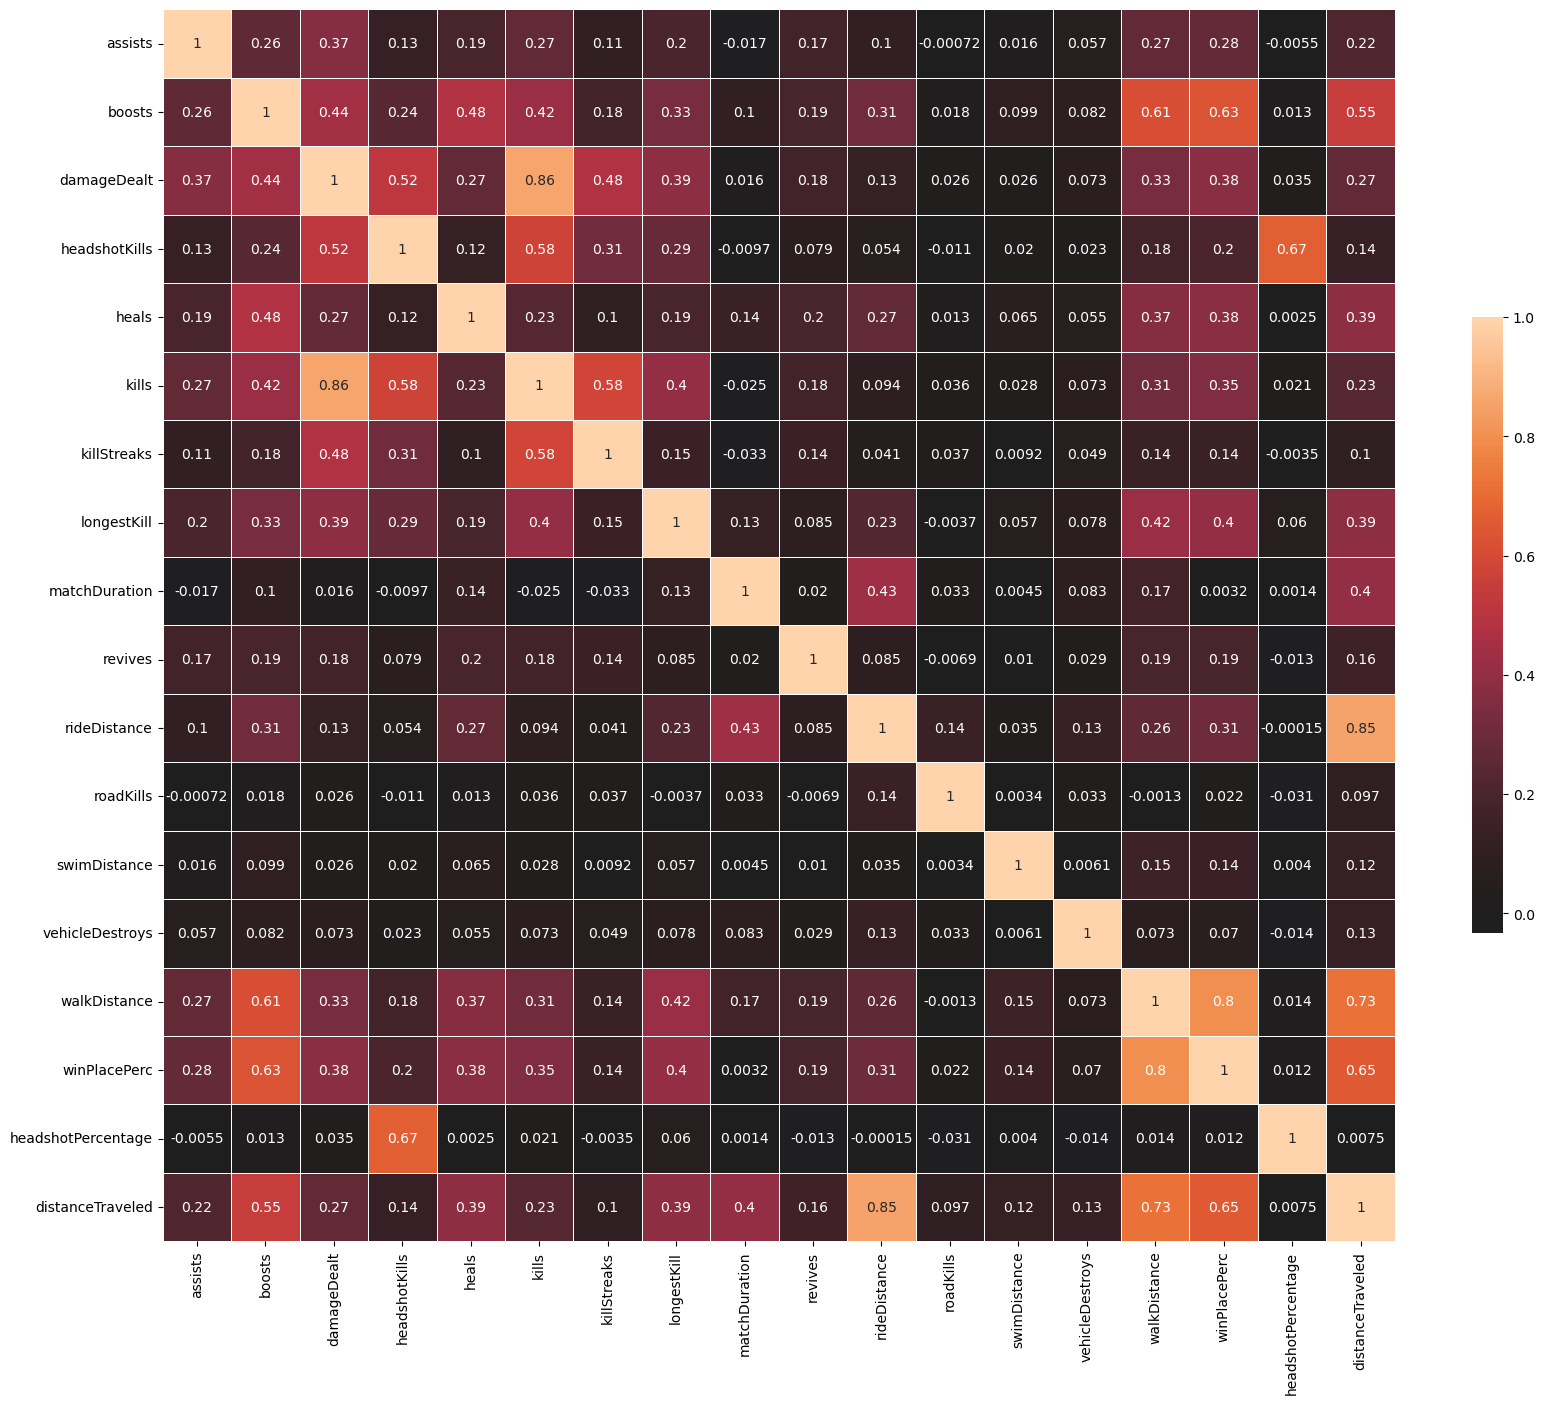

In [11]:
#Correlation Heatmap for Continuous Variables

no_cat_df = PUBG_DF.drop(columns = ['matchType'])

corr = no_cat_df.corr()

cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.figure(figsize=(20,16))

sns.heatmap(corr, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Univariate Exploration

Text(0.5, 1.0, 'Win Percentage Distribution')

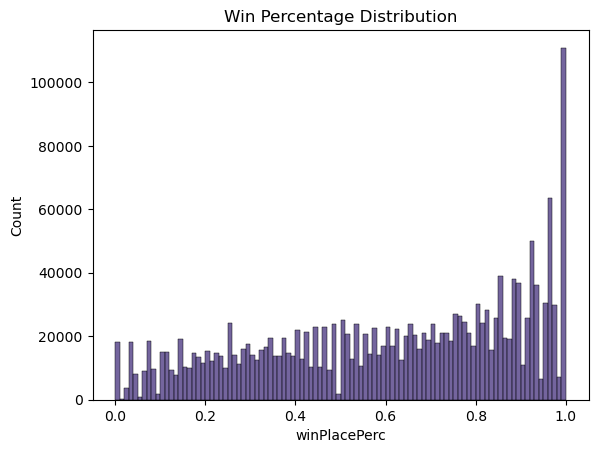

In [12]:
#Win Percentage Distribution (1 = Win)

sns.histplot(data = PUBG_DF, x = 'winPlacePerc', bins = 100)
plt.title("Win Percentage Distribution")

In [13]:
#Win Distribution

Win = PUBG_DF.loc[PUBG_DF['winPlacePerc'] == 1.0]

print(f'Percentage of wins to entire dataset: {round(len(Win) / len(PUBG_DF),3)*100}%')

Percentage of wins to entire dataset: 5.800000000000001%


In [14]:
#Average and Max Kills

Average_Kills = PUBG_DF['kills'].mean()
Max_Kills = PUBG_DF['kills'].max()

print(f'Average Overall Kills: {Average_Kills}, Max Kills: {Max_Kills}')

Average Overall Kills: 2.1449956291426653, Max Kills: 72


Text(0.5, 1.0, 'Kill Distribution')

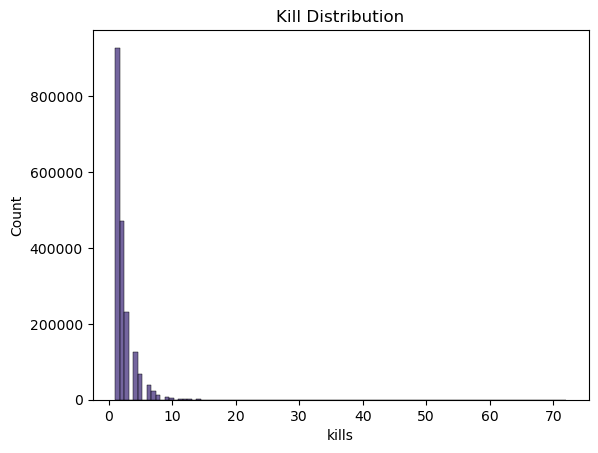

In [15]:
# Histplot

sns.histplot(data = PUBG_DF, x = 'kills', bins = 100)
plt.title("Kill Distribution")

In [16]:
# Look at kills above 95 percentile

Kills_Over_5 = PUBG_DF.loc[PUBG_DF['kills'] > 5]

print(f'Percentage of Kills over 5: {round(len(Kills_Over_5) / len(PUBG_DF),3)*100}%')

Percentage of Kills over 5: 4.9%


Text(0, 0.5, 'Ordered Values')

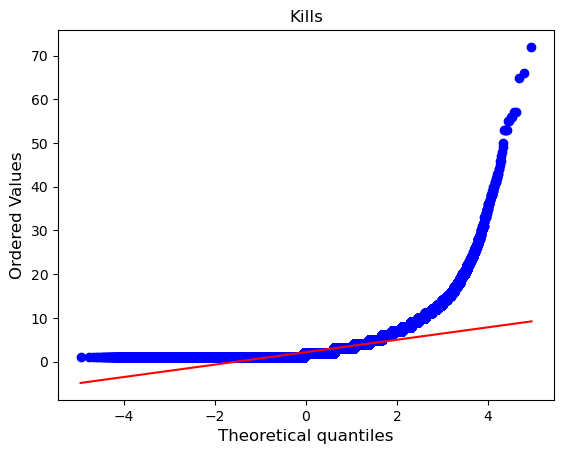

In [17]:
# Probability plots

stats.probplot(PUBG_DF["kills"], plot = sns.mpl.pyplot)
plt.title('Kills', fontsize = 12)
plt.xlabel('Theoretical quantiles', fontsize = 12)
plt.ylabel('Ordered Values', fontsize = 12)

Text(0.5, 1.0, 'Walk Distance')

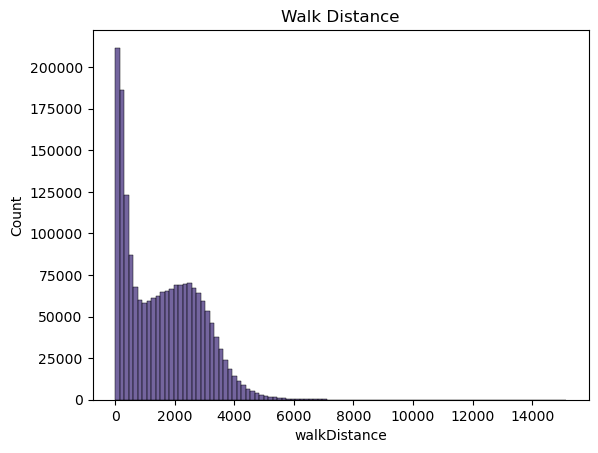

In [18]:
#Walk Distance

sns.histplot(data = PUBG_DF, x = 'walkDistance', bins = 100)
plt.title("Walk Distance")

In [19]:
#Walk Mean, Max

Average_Walk = PUBG_DF['walkDistance'].mean()
Max_Walk = PUBG_DF['walkDistance'].max()

print(f'Average Overall Walk: {Average_Walk}, Max Walk: {Max_Walk}')

Average Overall Walk: 1591.363857941467, Max Walk: 15130.0


In [20]:
# Look at walk distance 95th percentile

Walk_Over_3000 = PUBG_DF.loc[PUBG_DF['walkDistance'] > 3500]

print(f'Percentage of walk distance over 3500: {round(len(Walk_Over_3000) / len(PUBG_DF),3)*100} %')

Percentage of walk distance over 3500: 6.9 %


Text(0, 0.5, 'Ordered Values')

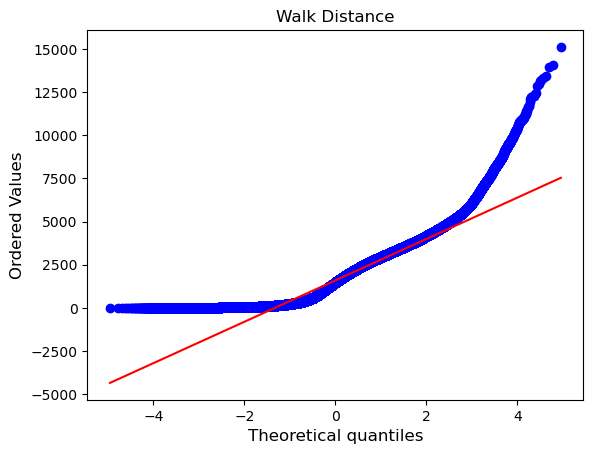

In [21]:
#Probability 

stats.probplot(PUBG_DF["walkDistance"], plot = sns.mpl.pyplot)
plt.title('Walk Distance', fontsize = 12)
plt.xlabel('Theoretical quantiles', fontsize = 12)
plt.ylabel('Ordered Values', fontsize = 12)

Text(0.5, 1.0, 'Boosts')

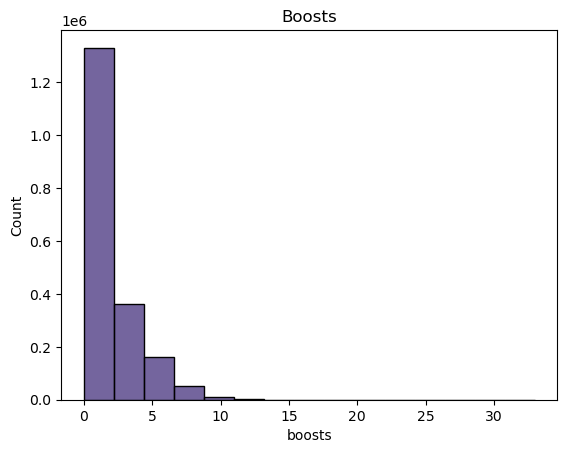

In [22]:
#Boosts

sns.histplot(data = PUBG_DF, x = 'boosts', bins = 15)
plt.title("Boosts")

In [23]:
#Mean and Max Boosts

boosts_mean = PUBG_DF['boosts'].mean()
boosts_max = PUBG_DF['boosts'].max()
print(f'Boosts Mean: {boosts_mean} , Max Amount of Boosts: {boosts_max}')

Boosts Mean: 1.8665605421114893 , Max Amount of Boosts: 33


In [24]:
# Look at boost 95 percentile

Boost_95 = PUBG_DF.loc[PUBG_DF['boosts'] > 5]

print(f'Percentage of boosts above 5: {round(len(Boost_95)*100 / len(PUBG_DF),3)} %')

Percentage of boosts above 5: 6.593 %


Text(0, 0.5, 'Ordered Values')

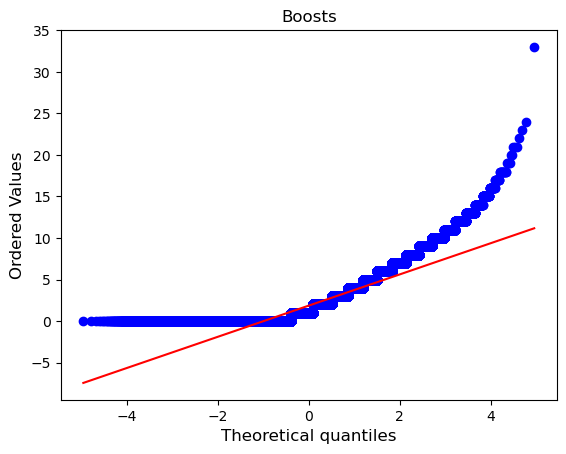

In [25]:
stats.probplot(PUBG_DF["boosts"], plot = sns.mpl.pyplot)
plt.title('Boosts', fontsize = 12)
plt.xlabel('Theoretical quantiles', fontsize = 12)
plt.ylabel('Ordered Values', fontsize = 12)

Text(0.5, 1.0, 'Longest Kill')

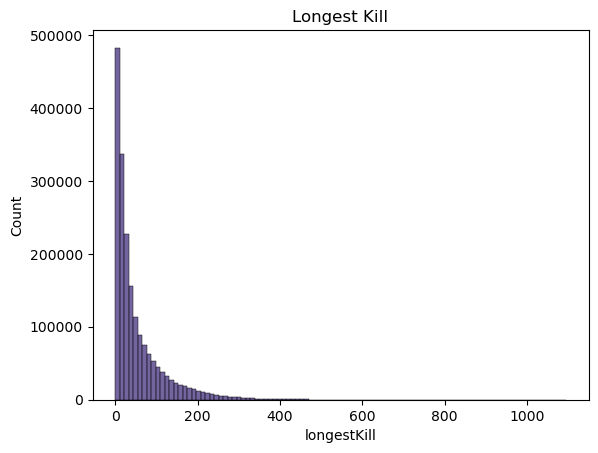

In [26]:
#Longest Kill

sns.histplot(data = PUBG_DF, x = 'longestKill', bins = 100)
plt.title("Longest Kill")

In [27]:
#Mean and Max Longest Kill

longest_kill_mean = PUBG_DF['longestKill'].mean()
longest_kill_max = PUBG_DF['longestKill'].max()

print(f'Longest Kill Mean: {longest_kill_mean}, Longest Kill Max: {longest_kill_max}')

Longest Kill Mean: 53.341944144303675, Longest Kill Max: 1094.0


In [28]:
#95% percentile

longest_95 = PUBG_DF.loc[PUBG_DF['longestKill'] > 200]

print(f'Percentage of longest kill greater than 200: {round(len(longest_95) / len(PUBG_DF),3)*100} %')

Percentage of longest kill greater than 200: 4.3 %


Text(0, 0.5, 'Ordered Values')

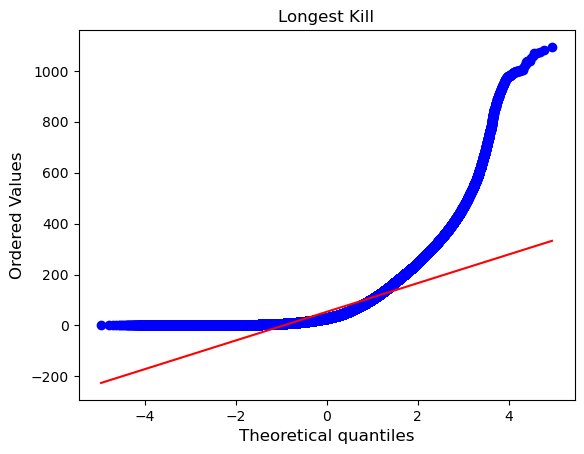

In [29]:
stats.probplot(PUBG_DF["longestKill"], plot = sns.mpl.pyplot)
plt.title('Longest Kill', fontsize = 12)
plt.xlabel('Theoretical quantiles', fontsize = 12)
plt.ylabel('Ordered Values', fontsize = 12)

Text(0.5, 1.0, 'Damage Dealt')

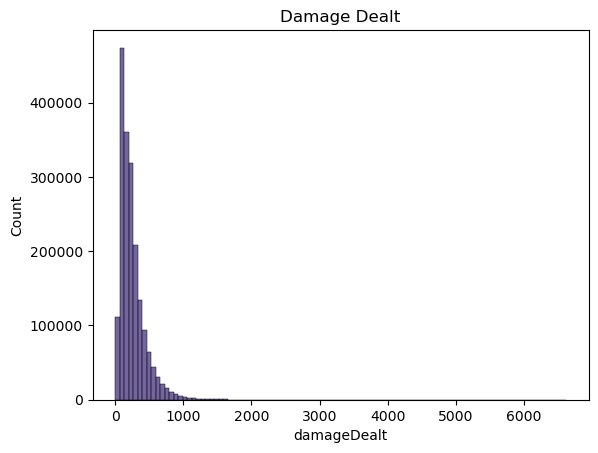

In [30]:
#Damage Dealt

sns.histplot(data = PUBG_DF, x = 'damageDealt', bins = 100)
plt.title("Damage Dealt")

Text(0.5, 1.0, 'Headshot Percentage')

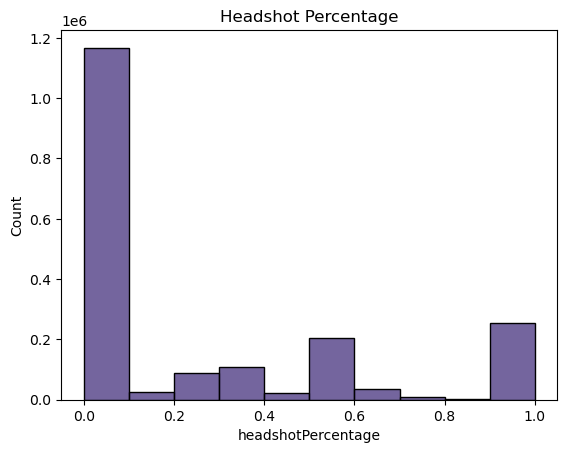

In [31]:
#Headshot Percentage

sns.histplot(data = PUBG_DF, x = 'headshotPercentage', bins = 10)
plt.title("Headshot Percentage")

# Bivariate Exploration

Text(0.5, 1.0, 'Kills vs. Win Place')

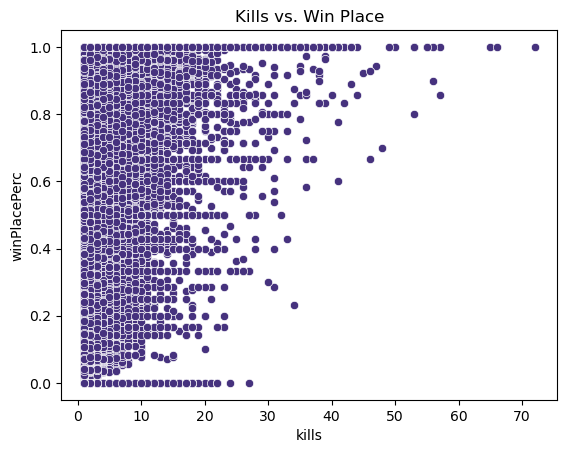

In [32]:
#Kills vs. Place (closer to 1 means higher placement)

sns.scatterplot(data = PUBG_DF, x = "kills", y = "winPlacePerc")
plt.title("Kills vs. Win Place")

Text(0.5, 1.0, 'Kills vs. Headshot Kills')

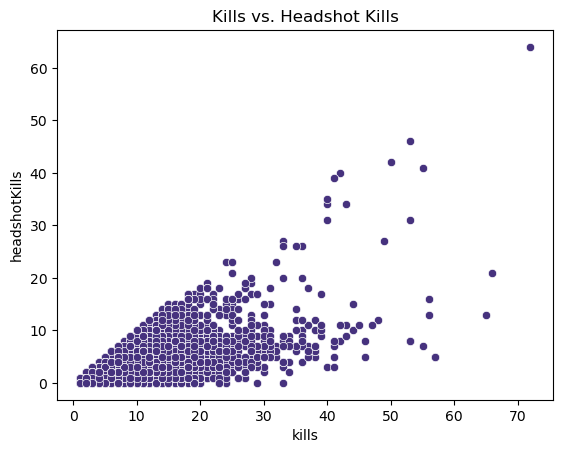

In [33]:
#Examining the relationship between kill counts and headshot kills
sns.scatterplot(data = PUBG_DF, x = "kills", y = "headshotKills")
plt.title("Kills vs. Headshot Kills")

There seems to be some markings of a linear relationship here in the higher outliers

Average Kills: 2.1449956291426653, Average Distance Traveled: 2368.2053743570377


Text(0.5, 1.0, 'Kills vs. Distance Traveled')

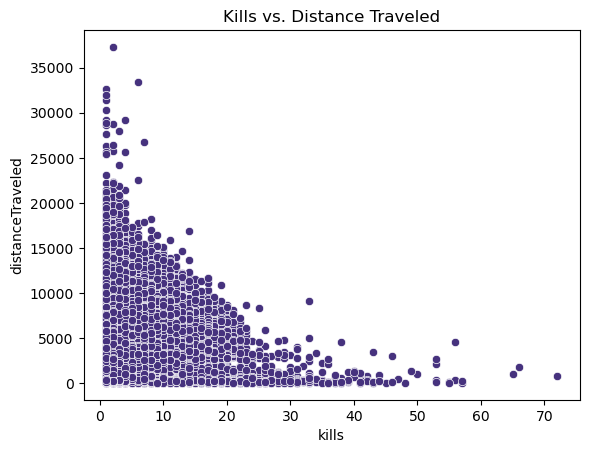

In [34]:
#Examining Kills vs. Distance Traveled to look for interesting relationships

Average_Distance = PUBG_DF['distanceTraveled'].mean()
print(f'Average Kills: {Average_Kills}, Average Distance Traveled: {Average_Distance}')

sns.scatterplot(data = PUBG_DF, x = "kills", y = "distanceTraveled")
plt.title("Kills vs. Distance Traveled")

Another linear looking graph with the highest kills correlating to low distance traveled - an impossible event for a real player.

Average Kills: 2.1449956291426653, Average Longest Kill: 53.341944144303675


Text(0.5, 1.0, 'Kills vs. Longest Kill')

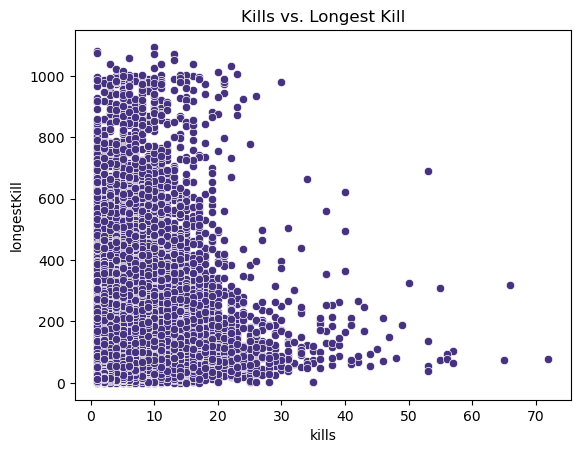

In [35]:
#Kills vs. Longest Kill

Average_longest = PUBG_DF['longestKill'].mean()
print(f'Average Kills: {Average_Kills}, Average Longest Kill: {Average_longest}')

sns.scatterplot(data = PUBG_DF, x = "kills", y = "longestKill")
plt.title("Kills vs. Longest Kill")

Average Kills: 2.1449956291426653, Average Kill Streak: 1.2616808293571398


Text(0.5, 1.0, 'Kills vs. Killstreaks')

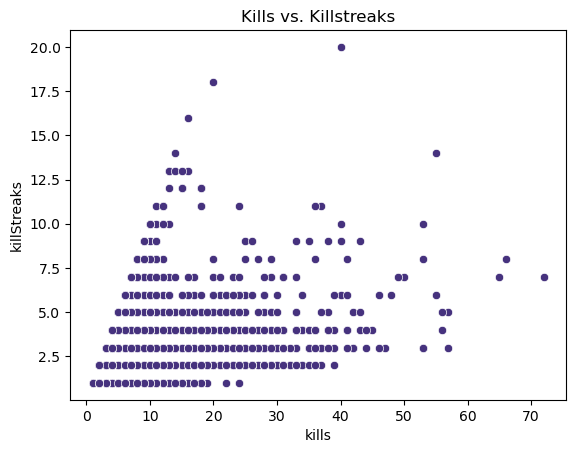

In [36]:
#Kills vs. Killstreaks

Average_killstreak = PUBG_DF['killStreaks'].mean()
print(f'Average Kills: {Average_Kills}, Average Kill Streak: {Average_killstreak}')

sns.scatterplot(data = PUBG_DF, x = "kills", y = "killStreaks")
plt.title("Kills vs. Killstreaks")

Average Kills: 2.1449956291426653, Average Match Duration: 1571.3410577892016


Text(0.5, 1.0, 'Kills vs. Match Duration')

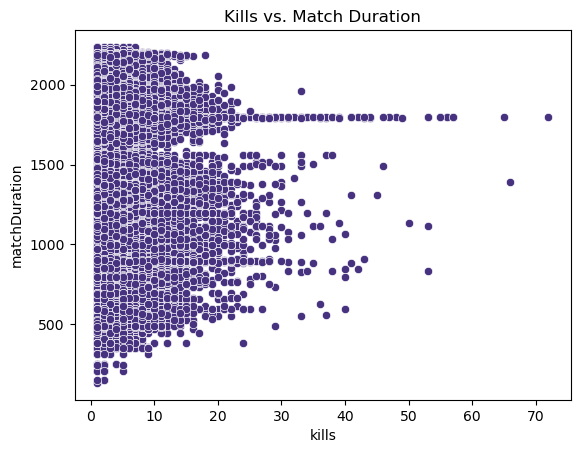

In [37]:
#Kills vs. Match Duration

Average_matchd = PUBG_DF['matchDuration'].mean()
print(f'Average Kills: {Average_Kills}, Average Match Duration: {Average_matchd}')

sns.scatterplot(data = PUBG_DF, x = "kills", y = "matchDuration")
plt.title("Kills vs. Match Duration")

Text(0.5, 1.0, 'Kills vs. Match Type')

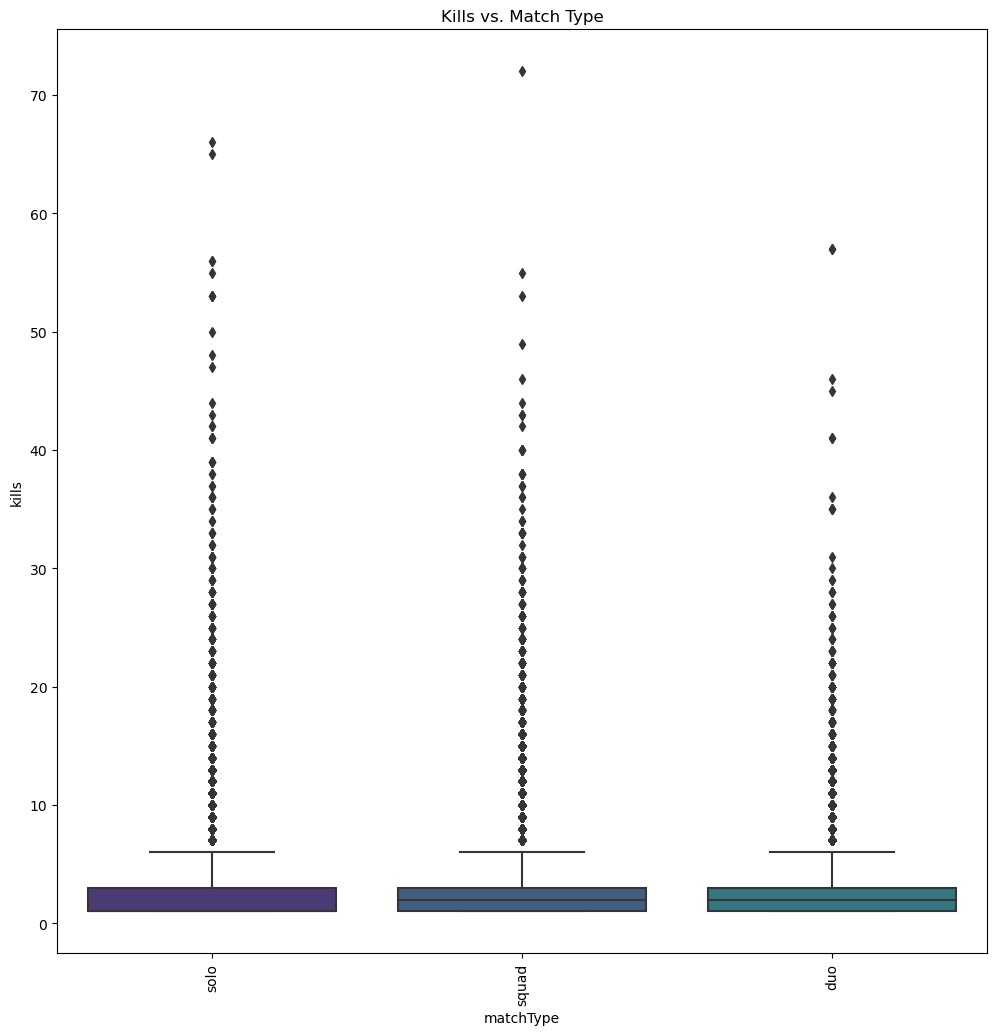

In [38]:
#Kills vs. Match Type

plt.figure(figsize=(12,12))
sns.boxplot(data = PUBG_DF, x = "matchType", y = "kills")
plt.xticks(rotation=90)
plt.title("Kills vs. Match Type")

# Multivariate Kills Exploration

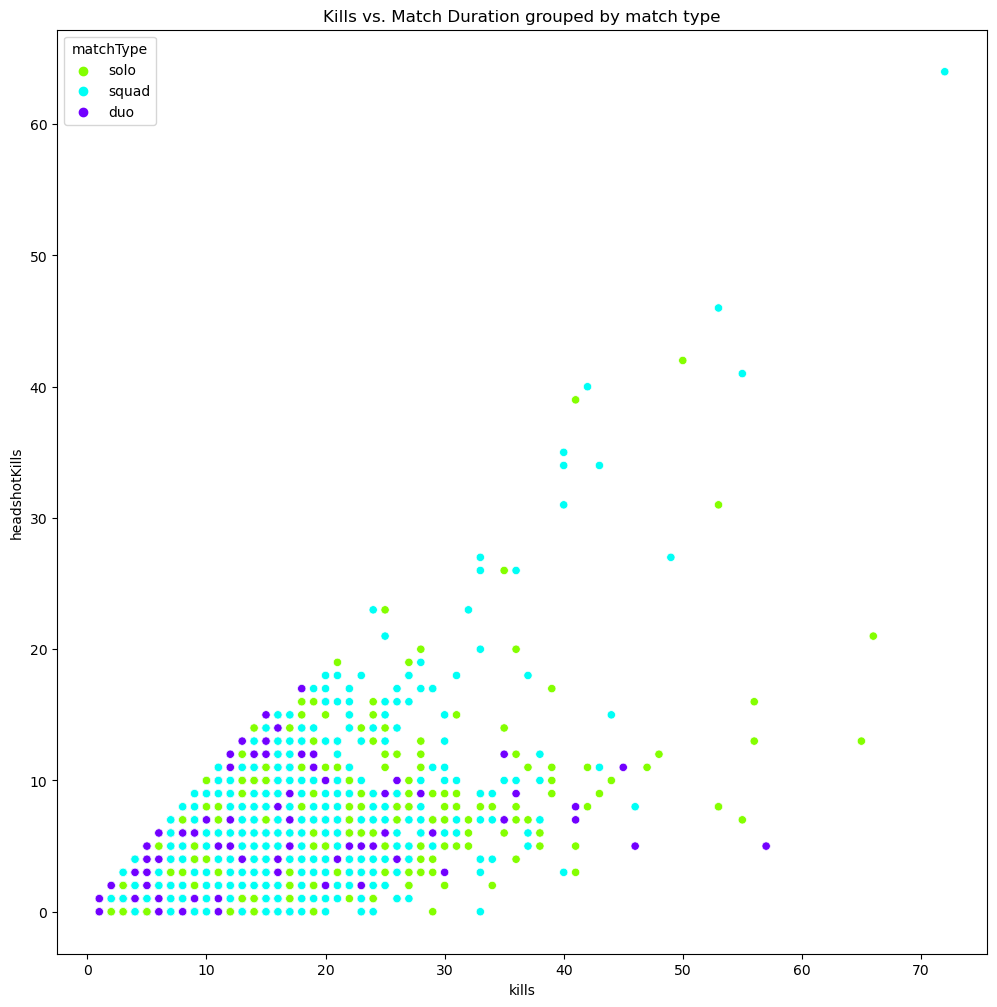

In [39]:
#Kills vs Headshot Kills grouped by match type
with sns.color_palette("hsv", n_colors=3):
    plt.figure(figsize=(12,12))
    sns.scatterplot(data = PUBG_DF, x = "kills", y = "headshotKills", hue = 'matchType')
    plt.title("Kills vs. Match Duration grouped by match type")

# Clustering Unlabeled Data

In [40]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

Cluster_X = PUBG_DF.drop(columns = ['killStreaks','damageDealt','assists','heals', 'roadKills','swimDistance','distanceTraveled','matchType','matchDuration','rideDistance','revives','vehicleDestroys'])

(array([-5.0e+11,  0.0e+00,  5.0e+11,  1.0e+12,  1.5e+12,  2.0e+12,
         2.5e+12,  3.0e+12,  3.5e+12]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

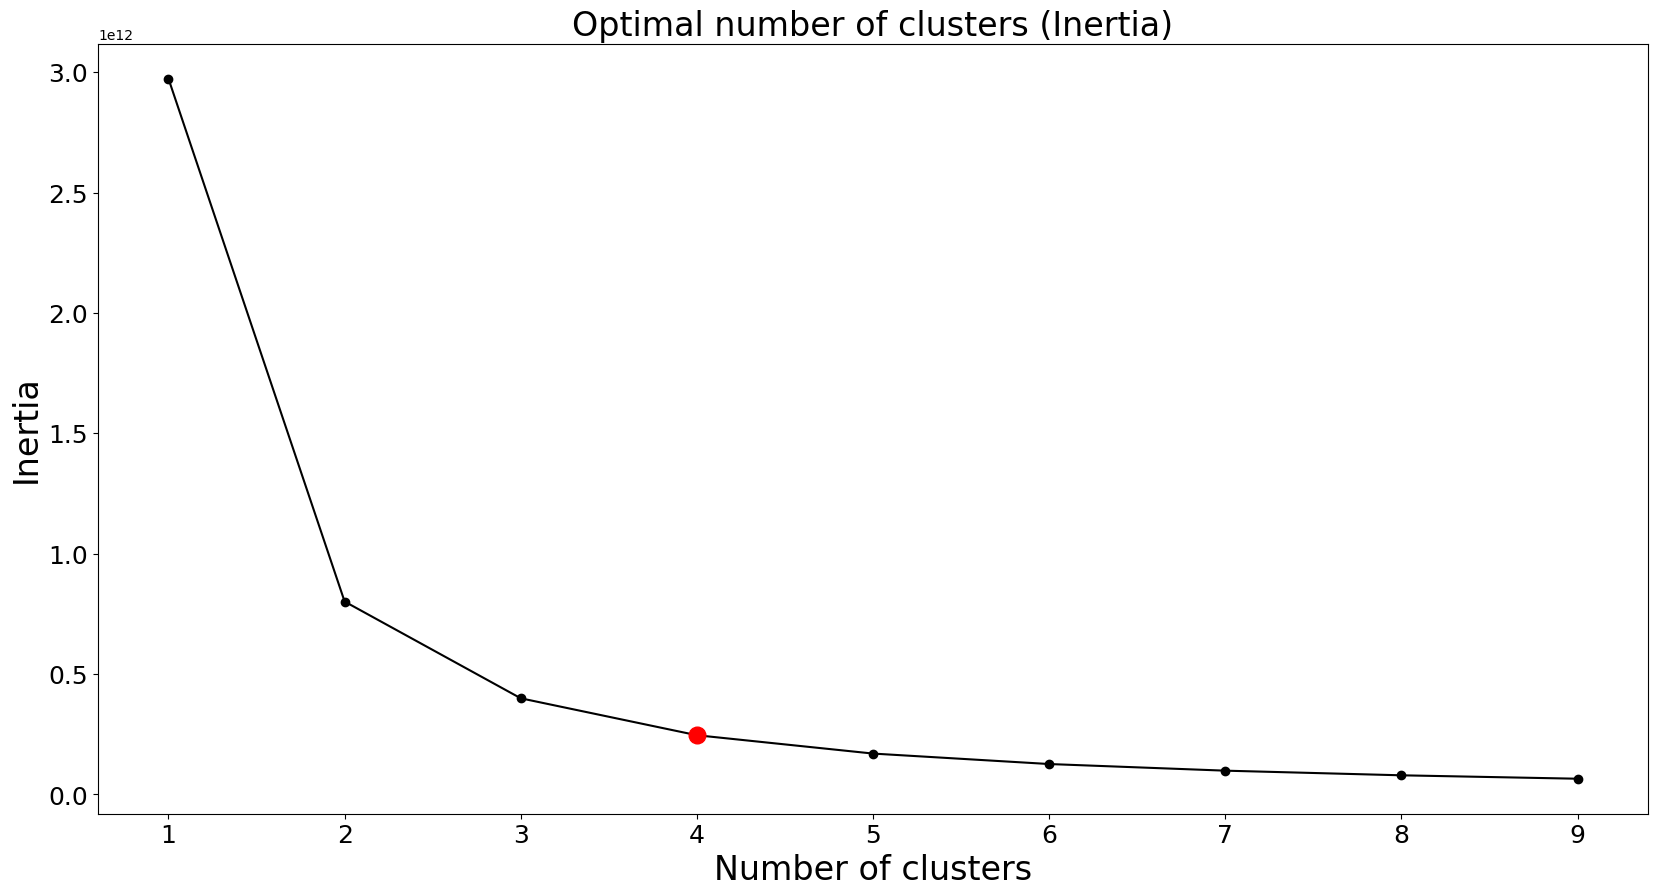

In [41]:
#Create a search for the optimal number of clusters

ks = range(1, 10)

inertias = []

for k in ks:
   
    # Create a KMeans instance with k clusters: model
    
    model = KMeans(n_clusters=k, init='k-means++', random_state = 42)
    
    # Fit model to samples
    model.fit(Cluster_X)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

# Plot parameters
plt.figure(figsize = (20, 10))
plt.plot(ks, inertias, '-o', color = 'black')
plt.plot(4, inertias[3], '-o', color = 'red', markersize = 12)
plt.xlabel('Number of clusters', fontsize = 24)
plt.ylabel('Inertia', fontsize = 24)
plt.title('Optimal number of clusters (Inertia)', fontsize = 24)
plt.xticks(ks, fontsize = 18)
plt.yticks(fontsize = 18)

In [42]:
#Instantiate the KMeans Model and predict on the training set

kmeans = KMeans(n_clusters = 4)

label = kmeans.fit_predict(Cluster_X)

centroids = kmeans.cluster_centers_

In [43]:
#Send labels to dataframe and display sample

Cluster_X['label'] = label.tolist()

Cluster_X.sample(n=20)

,boosts,headshotKills,kills,longestKill,walkDistance,winPlacePerc,headshotPercentage,label
394903,4,2,3,161.200,4126.0,0.7931,0.666667,2
203716,2,0,3,7.403,988.7,0.6129,0.000000,0
2037155,4,2,5,170.700,2588.0,1.0000,0.400000,3
1313379,1,1,1,2.617,934.8,0.3846,1.000000,1
1238061,1,1,4,51.560,1818.0,0.8105,0.250000,0
3943943,2,0,1,6.986,384.9,0.5532,0.000000,1
4264973,3,0,1,135.800,2635.0,1.0000,0.000000,3
677562,1,1,1,25.690,1248.0,0.4074,1.000000,0
4076392,4,1,2,3.102,2275.0,0.5833,0.500000,3
721438,0,0,1,16.680,440.1,0.4375,0.000000,1


In [ ]:
#Plot Label distribution

label_values = Cluster_X['label'].value_counts()

label_values.plot(kind = 'bar')

<AxesSubplot:>

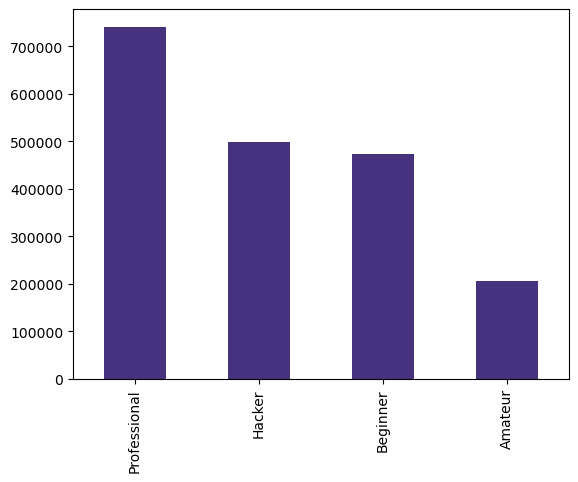

In [159]:
#Update labels

Cluster_X.loc[Cluster_X["label"] == 0, "label"] = "Beginner"
Cluster_X.loc[Cluster_X["label"] == 1, "label"] = "Amateur"
Cluster_X.loc[Cluster_X["label"] == 2, "label"] = "Professional"
Cluster_X.loc[Cluster_X["label"] == 3, "label"] = "Hacker"

label_values = Cluster_X['label'].value_counts()

label_values.plot(kind = 'bar')

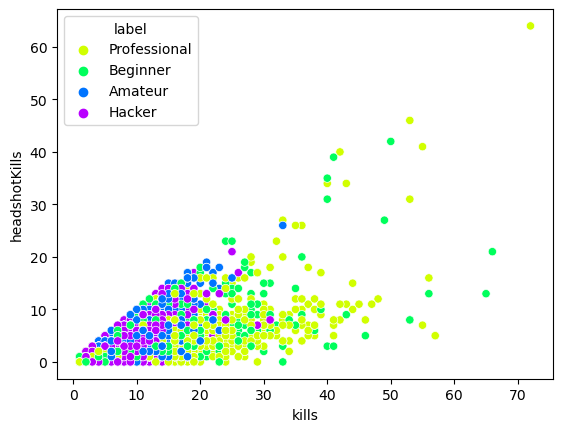

In [160]:
with sns.color_palette("hsv", n_colors=4):
    sns.scatterplot(x = 'kills', y = 'headshotKills', hue = 'label', data = Cluster_X)

Doesn't look like using a clustering algorithm off the bat to determine cheaters is working very well. The cluster for hackers isn't showing a skew to the anomalous behavior of high kills/high headshot kills like we suspected.

In [161]:
Hacker_X = Cluster_X.loc[Cluster_X["label"] == 'Hacker']

Hacker_X.sample(n = 20)

,boosts,headshotKills,kills,longestKill,walkDistance,winPlacePerc,headshotPercentage,label
2327496,3,1,5,122.900,2531.0,0.9783,0.200000,Hacker
1405292,2,2,3,47.800,2345.0,0.6786,0.666667,Hacker
1767599,3,0,1,182.300,3009.0,0.8511,0.000000,Hacker
76075,2,1,1,3.129,2527.0,0.9318,1.000000,Hacker
2246130,7,0,2,201.400,2946.0,0.9583,0.000000,Hacker
4403349,3,1,1,4.518,2488.0,0.7143,1.000000,Hacker
2489746,5,2,5,67.250,2499.0,0.8587,0.400000,Hacker
1844901,5,1,2,82.870,2087.0,0.7660,0.500000,Hacker
3081321,1,0,3,18.830,2525.0,0.7907,0.000000,Hacker
1702776,2,0,7,307.300,2095.0,0.8276,0.000000,Hacker


In [162]:
print(len(Hacker_X) / len(Cluster_X))

0.25930085059595964


So according to this clustering effort, about 25% of the players are cheaters but the behavior we expect from those cheaters is not being met and 25% being hackers is too large of a percentage.

# Outlier Detection

In [163]:
from sklearn.neighbors import LocalOutlierFactor

Outlier_X = PUBG_DF.drop(columns = ['killStreaks','damageDealt','assists','heals', 'roadKills','swimDistance','distanceTraveled','matchType','matchDuration','rideDistance','revives','vehicleDestroys'])

lof = LocalOutlierFactor(novelty=False)

outlier_predictions = lof.fit_predict(Outlier_X)

In [164]:
Outlier_X['label'] = outlier_predictions.tolist()

In [165]:
Outlier_X.loc[Outlier_X["label"] == 1, "label"] = "Normal Player"
Outlier_X.loc[Outlier_X["label"] == -1, "label"] = "Cheater"

In [166]:
Outlier_X.sample(20)

,boosts,headshotKills,kills,longestKill,walkDistance,winPlacePerc,headshotPercentage,label
3052575,0,1,1,29.230,447.80,0.4022,1.000000,Normal Player
1261189,1,0,1,24.720,939.40,0.3103,0.000000,Normal Player
2028569,0,0,3,12.530,1905.00,0.4894,0.000000,Normal Player
3256341,3,0,1,16.020,1821.00,0.4667,0.000000,Normal Player
928068,0,0,2,12.750,9.96,0.3750,0.000000,Normal Player
877739,0,0,3,12.090,177.70,0.2308,0.000000,Normal Player
3749331,0,0,1,1.348,1314.00,0.6923,0.000000,Normal Player
3458125,0,3,4,24.520,677.40,0.3404,0.750000,Normal Player
2064294,1,1,1,11.580,396.70,0.2653,1.000000,Normal Player
767693,1,0,2,48.630,863.40,0.5909,0.000000,Normal Player


<AxesSubplot:>

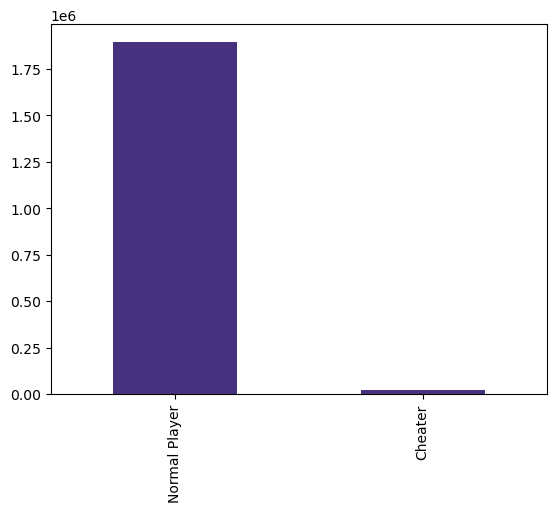

In [168]:
Outlier_X['label'].value_counts().plot(kind = 'bar')

In [169]:
Negative_Outliers = Outlier_X.loc[Outlier_X["label"] == 'Cheater']

In [170]:
Negative_Outliers.shape

(22317, 8)

In [171]:
print(len(Negative_Outliers)/len(Outlier_X))

0.011640145959512717


In [172]:
Negative_Outliers.sample(n=20)

,boosts,headshotKills,kills,longestKill,walkDistance,winPlacePerc,headshotPercentage,label
531814,1,0,1,8.4480,68.01,0.1429,0.000000,Cheater
2961336,3,1,5,6.6740,434.20,0.5769,0.200000,Cheater
4116556,0,0,1,6.4380,68.25,0.8214,0.000000,Cheater
4332210,9,3,16,94.1500,2813.00,1.0000,0.187500,Cheater
1219102,0,0,1,4.1270,54.87,0.7241,0.000000,Cheater
1221040,0,4,6,84.4000,1555.00,0.6429,0.666667,Cheater
2279062,0,4,4,1.6910,2689.00,0.6250,1.000000,Cheater
2440420,10,0,1,0.8249,2494.00,0.9615,0.000000,Cheater
2215801,0,11,47,148.4000,461.70,0.9444,0.234043,Cheater
1764024,1,1,1,2.4250,62.40,0.1979,1.000000,Cheater


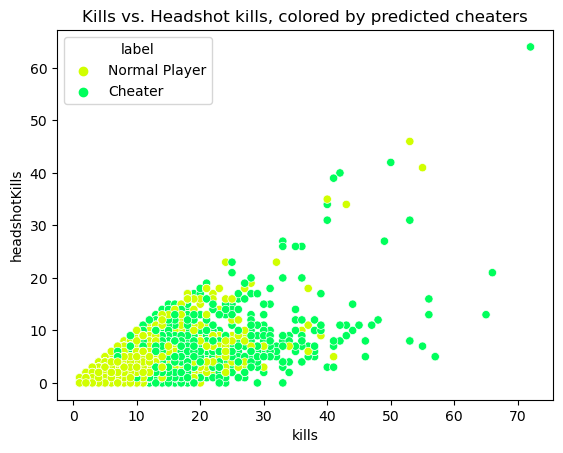

In [173]:
with sns.color_palette("hsv", n_colors=4):
    sns.scatterplot(x = 'kills', y = 'headshotKills', hue = 'label', data = Outlier_X)
    plt.title("Kills vs. Headshot kills, colored by predicted cheaters")

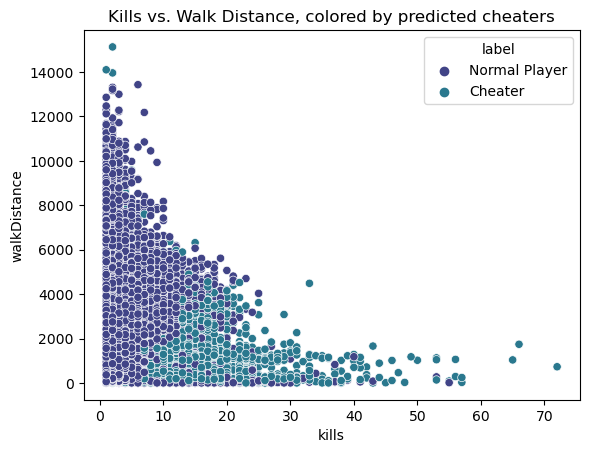

In [174]:
with sns.color_palette("viridis", n_colors=4):
    sns.scatterplot(x = 'kills', y = 'walkDistance', hue = 'label', data = Outlier_X)
    plt.title("Kills vs. Walk Distance, colored by predicted cheaters")

The outlier detection method is much more clear in dividing the more impossible feats into the cheater category, while still only selecting roughly one percent of participants.

# Rule Based Classifier for Labeling

In [175]:
Rule_Based_DF = PUBG_DF.drop(columns = ['killStreaks','damageDealt','assists','heals', 'roadKills','swimDistance','distanceTraveled','matchType','matchDuration','rideDistance','revives','vehicleDestroys'])

Rule_Based_DF

,boosts,headshotKills,kills,longestKill,walkDistance,winPlacePerc,headshotPercentage
4,0,0,1,58.530,49.75,0.1875,0.00
5,0,1,1,18.440,34.70,0.0370,1.00
13,1,1,4,49.830,2050.00,0.8750,0.25
14,1,0,1,37.910,1666.00,0.9000,0.00
16,2,0,1,9.158,3674.00,0.7308,0.00
...,...,...,...,...,...,...,...
4446950,0,0,1,11.270,1559.00,0.5000,0.00
4446957,1,0,1,12.020,363.70,0.4583,0.00
4446960,0,2,4,90.250,845.60,0.2414,0.50
4446964,4,1,2,98.500,2748.00,0.8000,0.50


In [176]:
def first_predict(df):
    
    predictions = []
    
    for index, row in df.iterrows():
        
        if row['kills'] > 10 and row['boosts'] > 5 and row['longestKill'] > 100 and row['winPlacePerc'] > 0.50 and row['walkDistance'] > 3000 and row['headshotPercentage'] > 0.75:
            predictions.append(1)
        else:
            predictions.append(0)
        
    return predictions

In [177]:
#Arbitrary Rules

Rule_Based_DF['label'] = first_predict(Rule_Based_DF)

In [178]:
Rule_Based_Cheaters = Rule_Based_DF.loc[Rule_Based_DF['label'] == 1]

Arbitrary_Rules = len(Rule_Based_Cheaters)/len(Rule_Based_DF)

print(Arbitrary_Rules)

1.982011679264611e-05


It's a good start, but let's assume for the sake of this project that we're looking for approximately 1% of players to be hacking. The current percentage is way less than 1%.

Let's use the 95th percentile for our most influential variables.

In [179]:
def better_predict(df):
    
    predictions = []
    
    for index, row in df.iterrows():
        
        if row['winPlacePerc'] == 1.0 and row['kills'] > 5 and row['walkDistance'] > 3500 and row['boosts'] > 5 and row['longestKill'] > 200:
            predictions.append(1)
        else:
            predictions.append(0)
        
    return predictions

In [180]:
Rule_Based_DF['label'] = better_predict(Rule_Based_DF)

In [181]:
Rule_Based_Cheaters = Rule_Based_DF.loc[Rule_Based_DF['label'] == 1]

Percentile_Rules = len(Rule_Based_Cheaters)/len(Rule_Based_DF)

print(f'Cheaters Detected: {Rule_Based_Cheaters.shape}, Cheater Percentage: {Percentile_Rules}')

Cheaters Detected: (1039, 8), Cheater Percentage: 0.0005419237196726134


In [182]:
Rule_Based_Cheaters.sample(n=20)

,boosts,headshotKills,kills,longestKill,walkDistance,winPlacePerc,headshotPercentage,label
4124964,6,4,6,212.7,3864.0,1.0,0.666667,1
1802530,6,2,6,204.2,4310.0,1.0,0.333333,1
3727313,6,1,16,274.2,4079.0,1.0,0.062500,1
1456028,6,2,8,433.8,3886.0,1.0,0.250000,1
1363001,9,5,15,249.9,3784.0,1.0,0.333333,1
1824740,6,1,9,209.9,3531.0,1.0,0.111111,1
269759,8,0,7,393.6,4072.0,1.0,0.000000,1
4278227,9,8,13,202.5,3773.0,1.0,0.615385,1
994149,10,1,11,448.4,4065.0,1.0,0.090909,1
3923805,6,2,6,215.4,3538.0,1.0,0.333333,1


We've created a better way to determine the highest end player and at least annotate that they might be a hacker/cheater - but our percentage is still far lower than 1%. We'll have to continue manipulating some of the fields. 

Regardless of the influence on win place percentage - boosts are not likely to be a very good confirmation of a hacker (boosts are readily available to all players and there have no been hacks reported that allow people to spawn more boosts).

We will remove boosts in this iteration.

In [183]:
def no_boost_predict(df):
    
    predictions = []
    
    for index, row in df.iterrows():
        
        if row['winPlacePerc'] == 1.0 and row['kills'] > 5 and row['walkDistance'] > 3500 and row['longestKill'] > 200:
            predictions.append(1)
        else:
            predictions.append(0)
        
    return predictions

In [184]:
Rule_Based_DF['label'] = no_boost_predict(Rule_Based_DF)

Rule_Based_Cheaters = Rule_Based_DF.loc[Rule_Based_DF['label'] == 1]

No_Boost_Rule = len(Rule_Based_Cheaters)/len(Rule_Based_DF)

print(f'Cheaters Detected: {Rule_Based_Cheaters.shape}, Cheater Percentage: {No_Boost_Rule}')

Cheaters Detected: (2455, 8), Cheater Percentage: 0.0012804838612091105


In [185]:
Rule_Based_Cheaters.sample(n=20)

,boosts,headshotKills,kills,longestKill,walkDistance,winPlacePerc,headshotPercentage,label
145921,4,4,7,268.5,3639.0,1.0,0.571429,1
3055583,11,3,6,395.3,3850.0,1.0,0.500000,1
2754082,9,2,8,271.7,3935.0,1.0,0.250000,1
3256722,5,3,15,351.6,3612.0,1.0,0.200000,1
406096,5,3,6,286.9,3571.0,1.0,0.500000,1
1823039,6,2,9,345.9,3639.0,1.0,0.222222,1
2491294,2,5,8,790.2,3609.0,1.0,0.625000,1
1306304,7,1,6,258.8,4102.0,1.0,0.166667,1
3189074,2,1,8,222.7,3787.0,1.0,0.125000,1
3374641,6,4,11,226.2,4453.0,1.0,0.363636,1


This iteration proved to be better in getting us closer to the 1% threshold. 

Next we'll take a look at some impossible events like high kills without large walk distances.

In [186]:
def low_walk_predict(df):
    
    predictions = []
    
    for index, row in df.iterrows():
        
        if row['winPlacePerc'] == 1.0 and row['kills'] > 5 and row['walkDistance'] < 1000 and row['longestKill'] > 200:
            predictions.append(1)
        else:
            predictions.append(0)
        
    return predictions

In [187]:
Rule_Based_DF['label'] = low_walk_predict(Rule_Based_DF)

Rule_Based_Cheaters = Rule_Based_DF.loc[Rule_Based_DF['label'] == 1]

Low_Walk_Rule = len(Rule_Based_Cheaters)/len(Rule_Based_DF)

print(f'Cheaters Detected: {Rule_Based_Cheaters.shape}, Cheater Percentage: {Low_Walk_Rule}')

Cheaters Detected: (75, 8), Cheater Percentage: 3.911865156443311e-05


In [188]:
Rule_Based_Cheaters.sample(n=20)

,boosts,headshotKills,kills,longestKill,walkDistance,winPlacePerc,headshotPercentage,label
518501,0,3,10,217.5,548.60,1.0,0.300000,1
2280520,4,2,8,226.2,845.60,1.0,0.250000,1
2348776,0,5,20,312.0,580.10,1.0,0.250000,1
1955074,0,16,20,389.6,0.00,1.0,0.800000,1
1137057,0,16,24,210.3,46.46,1.0,0.666667,1
3251183,1,6,9,248.6,364.60,1.0,0.666667,1
829086,1,10,36,200.9,64.94,1.0,0.277778,1
3342279,0,3,13,202.6,31.72,1.0,0.230769,1
1747819,0,19,28,234.8,38.96,1.0,0.678571,1
2442265,0,2,11,220.5,0.00,1.0,0.181818,1


Let's combine some of the impossible events with the near impossible events for our last prediction

In [189]:
def combined_predict(df):
    
    predictions = []
    
    for index, row in df.iterrows():
        
        if row['winPlacePerc'] == 1.0 and row['kills'] > 5 and row['longestKill'] > 200:
            predictions.append(1)
        else:
            predictions.append(0)
        
    return predictions

In [190]:
#Have to do some slight changes because the function wouldn't let me do it properly

Rule_Based_DF_Final = Rule_Based_DF[(Rule_Based_DF["walkDistance"] < 1000) | (Rule_Based_DF["walkDistance"] >= 3000)]

In [191]:
Rule_Based_DF_Final['label'] = combined_predict(Rule_Based_DF_Final)

C:\Users\lmoor\AppData\Local\Temp\ipykernel_9160\3038355406.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Rule_Based_DF_Final['label'] = combined_predict(Rule_Based_DF_Final)


In [192]:
Rule_Based_Cheaters = Rule_Based_DF_Final.loc[Rule_Based_DF_Final['label'] == 1]
Rule_Based_Cheaters.sample(n=20)

,boosts,headshotKills,kills,longestKill,walkDistance,winPlacePerc,headshotPercentage,label
2209661,0,1,15,236.6,118.2,1.0,0.066667,1
2618285,4,1,7,211.4,3010.0,1.0,0.142857,1
4204464,2,3,7,245.7,3813.0,1.0,0.428571,1
2769306,9,1,14,211.6,3061.0,1.0,0.071429,1
3053288,3,4,9,351.2,3552.0,1.0,0.444444,1
2292300,7,1,8,208.4,3338.0,1.0,0.125000,1
288130,8,0,12,322.7,4209.0,1.0,0.000000,1
219749,9,1,8,315.3,4452.0,1.0,0.125000,1
1605668,0,0,6,326.9,3744.0,1.0,0.000000,1
3397315,7,0,7,206.1,3413.0,1.0,0.000000,1


In [193]:
Rule_Based_Cheaters = Rule_Based_DF_Final.loc[Rule_Based_DF_Final['label'] == 1]

Combined_Rules = len(Rule_Based_Cheaters)/len(Rule_Based_DF)

print(f'Cheaters Detected: {Rule_Based_Cheaters.shape}, Cheater Percentage: {Combined_Rules}')

Cheaters Detected: (4360, 8), Cheater Percentage: 0.0022740976109457117


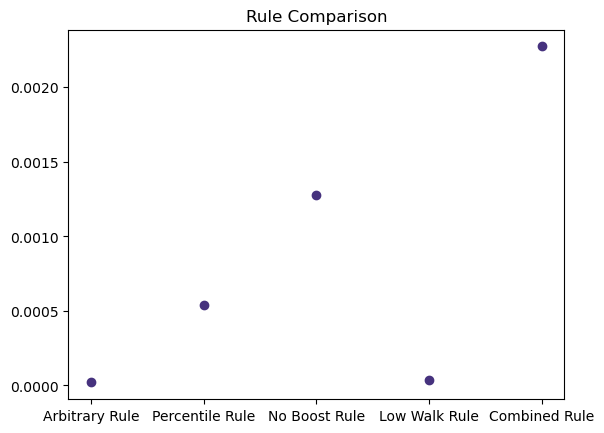

In [194]:
#Dictionary for the rule percentages

Rule_Dict = {"Arbitrary Rule": Arbitrary_Rules, "Percentile Rule": Percentile_Rules,"No Boost Rule": No_Boost_Rule, "Low Walk Rule": Low_Walk_Rule, "Combined Rule": Combined_Rules}
    
colors = list("rgbcmyk")

x = Rule_Dict.keys()

y = Rule_Dict.values()

plt.scatter(x,y)
plt.title("Rule Comparison")
plt.show()